# **AN2DL Second Challenge**
> ## ***Ibuprofen*** team

## 🌐 **Google Drive Connection**

In [8]:
from google.colab import drive
drive.mount("/gdrive")

working_dir = "/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Second Challenge/v0"
input_dir = "/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Second Challenge"

%cd $working_dir

print(f"Working at folder: {working_dir}")
print(f"Input at folder: {input_dir}")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Second Challenge/v0
Working at folder: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Second Challenge/v0
Input at folder: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Second Challenge


---
## ⚙️ **Libraries Import**

In [42]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
!pip install torchview
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
import shutil
from tqdm import tqdm  # Progress bar

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu126
Device: cpu


---
## ⏳ **Data unzip**

In [11]:
dataset_name = "an2dl2526c2"

dataset_zip = f"{input_dir}/{dataset_name}.zip"
dataset_dir = f"{input_dir}/grumpy-doctogres"


#===============================================================================
# --- UNZIP --------------------------------------------------------------------
#===============================================================================
# Check if data directory exists
if not os.path.exists(dataset_dir):
  print(f"Dataset folder '{dataset_dir}' not found. Checking for zip file...")
  # Check if zip file exists
  if os.path.exists(dataset_zip):
    print(f"Zip file '{dataset_zip}' found. Unzipping...")
    try:
      !unzip -q "{dataset_zip}" -d "{dataset_dir}/"
      print(f"Dataset '{dataset_name}' unzipped successfully to '{dataset_dir}'.")
    except Exception as e:
      print(f"Error during unzipping '{dataset_zip}': {e}")
      print("Data loading aborted due to unzipping error.")
  else:
    print(f"Error: Zip file '{dataset_zip}' not found. Cannot load data.")
else:
  print(f"Dataset folder found for '{dataset_name}': {dataset_dir}.")

Dataset folder found for 'an2dl2526c2': /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Second Challenge/grumpy-doctogres.


## 📥 **Dataset class and raw data loading**

In [75]:
class GrumpyDoctogresDataset(Dataset):
    def __init__(self, root_dir, mode='train',
                 data_dir=None, labels_df=None, filter_indices=None,
                 transform=None):
        """
        Args:
            root_dir (str): Path to the dataset root.
            mode (str): 'train' or 'test'.
            data_dir (str): Name of the training/test directory
            labels_df (pd.DataFrame): The pandas DataFrame containing the labels (required for mode='train').
            filter_indices (list, optional): List of indices to keep from the dataframe.
            transform (callable, optional): Transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform

        self.label_mapping = {
            'Luminal A': 0,
            'Luminal B': 1,
            'HER2(+)': 2,
            'Triple negative': 3
        }

        # Setup paths
        self.data_dir = os.path.join(root_dir, data_dir)

        # Initialize lists
        self.image_filenames = []
        self.mask_filenames = []
        self.labels = []

        if self.mode == 'train':
            if labels_df is None:
                raise ValueError("For mode='train', you must provide 'labels_df'.")

            # Work on a copy to avoid side effects
            self.df_labels = labels_df.copy()

            # Apply filter (Train/Val split)
            if filter_indices is not None:
                self.df_labels = self.df_labels.iloc[filter_indices].reset_index(drop=True)
                print(f"ℹ️ Subset initialized: {len(self.df_labels)} samples.")

            # 'sample_index' contains "img_XXXX.png"
            self.image_filenames = self.df_labels['sample_index'].tolist()
            self.labels = self.df_labels['label'].tolist()

            # Logic: "img_XXXX.png" -> "mask_XXXX.png"
            self.mask_filenames = [
                f.replace("img_", "mask_") for f in self.image_filenames
            ]

        elif self.mode == 'test':
            # In test mode, we scan the directory
            all_files = sorted(os.listdir(self.data_dir))

            # STRICT FILTER: Keep only files starting with "img_" and ending with .png
            self.image_filenames = [
                f for f in all_files
                if f.startswith('img_') and f.endswith('.png')
            ]

            # Generate mask filenames for test set as well
            self.mask_filenames = [
                f.replace("img_", "mask_") for f in self.image_filenames
            ]

    def __len__(self):
        return len(self.image_filenames)

    # TODO - WHEN WE WILL TRAIN A MODEL, PROVIDE HERE THE PROPER TENSOR
    # def __getitem__(self, index) -> _T_co:
    #    return ...

    def info(self, idx):
        sample = {
            'image': self.image(idx),
            'mask': self.mask(idx),
            'img_filename': self.image_filenames[idx],
            'mask_filename': self.mask_filenames[idx]
        }

        if self.mode == 'train':
            label_str = self.labels[idx]
            label = self.label_mapping[label_str]

            sample['label_str'] = label_str
            sample['label'] = torch.tensor(label, dtype=torch.long)

        # 6. Apply Transforms
        if self.transform:
            sample = self.transform(sample)

        return sample

    def image(self, idx):
        img_filename = self.image_filenames[idx]
        img_path = os.path.join(self.data_dir, img_filename)

        image = cv2.imread(img_path)
        if image is None:
             raise FileNotFoundError(f"Image not found at {img_path}")

        # BGR -> RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # [0,256] -> [0,1]
        image = (image / 255).astype(np.float32)

        return image

    def mask(self, idx):
        mask_filename = self.mask_filenames[idx]
        mask_path = os.path.join(self.data_dir, mask_filename)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
              # Fallback if file exists but is corrupted
              image = self.image(idx)
              mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        else:
            _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        return mask


# Load training dataset for EDA
ds_train = GrumpyDoctogresDataset(
    mode='train', root_dir=dataset_dir,
    data_dir='train_data',
    labels_df=pd.read_csv(os.path.join(dataset_dir, 'train_labels.csv')))
print(f"Loaded {len(ds_train)} training samples.")

Loaded 1412 training samples.


---
## 🔎 **Data inspection**

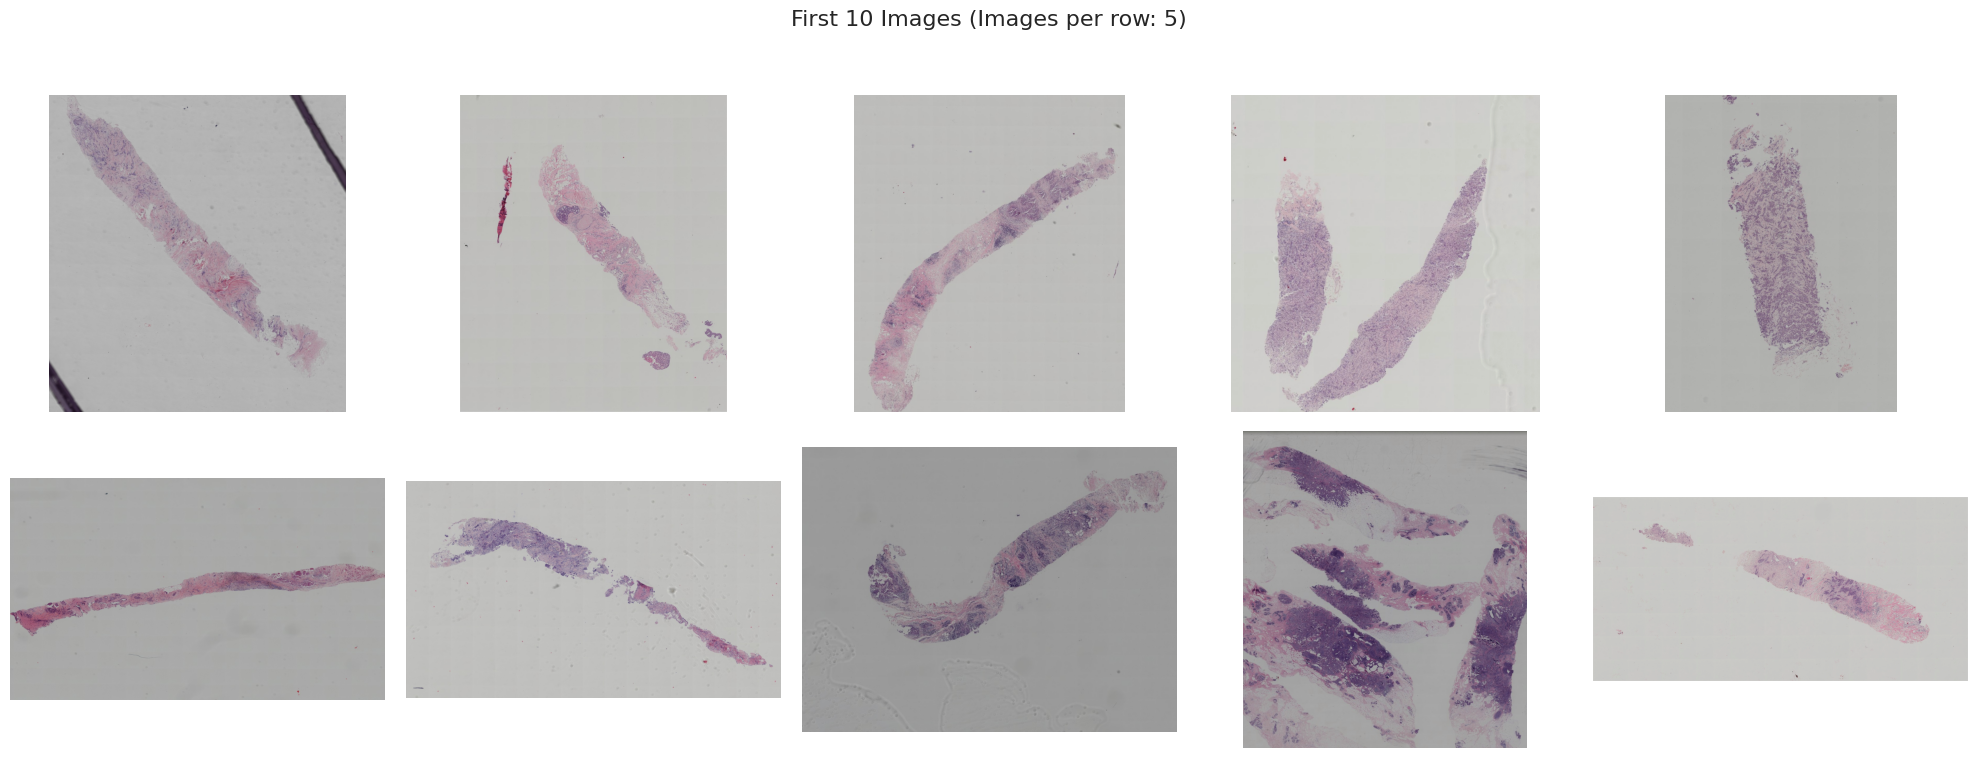

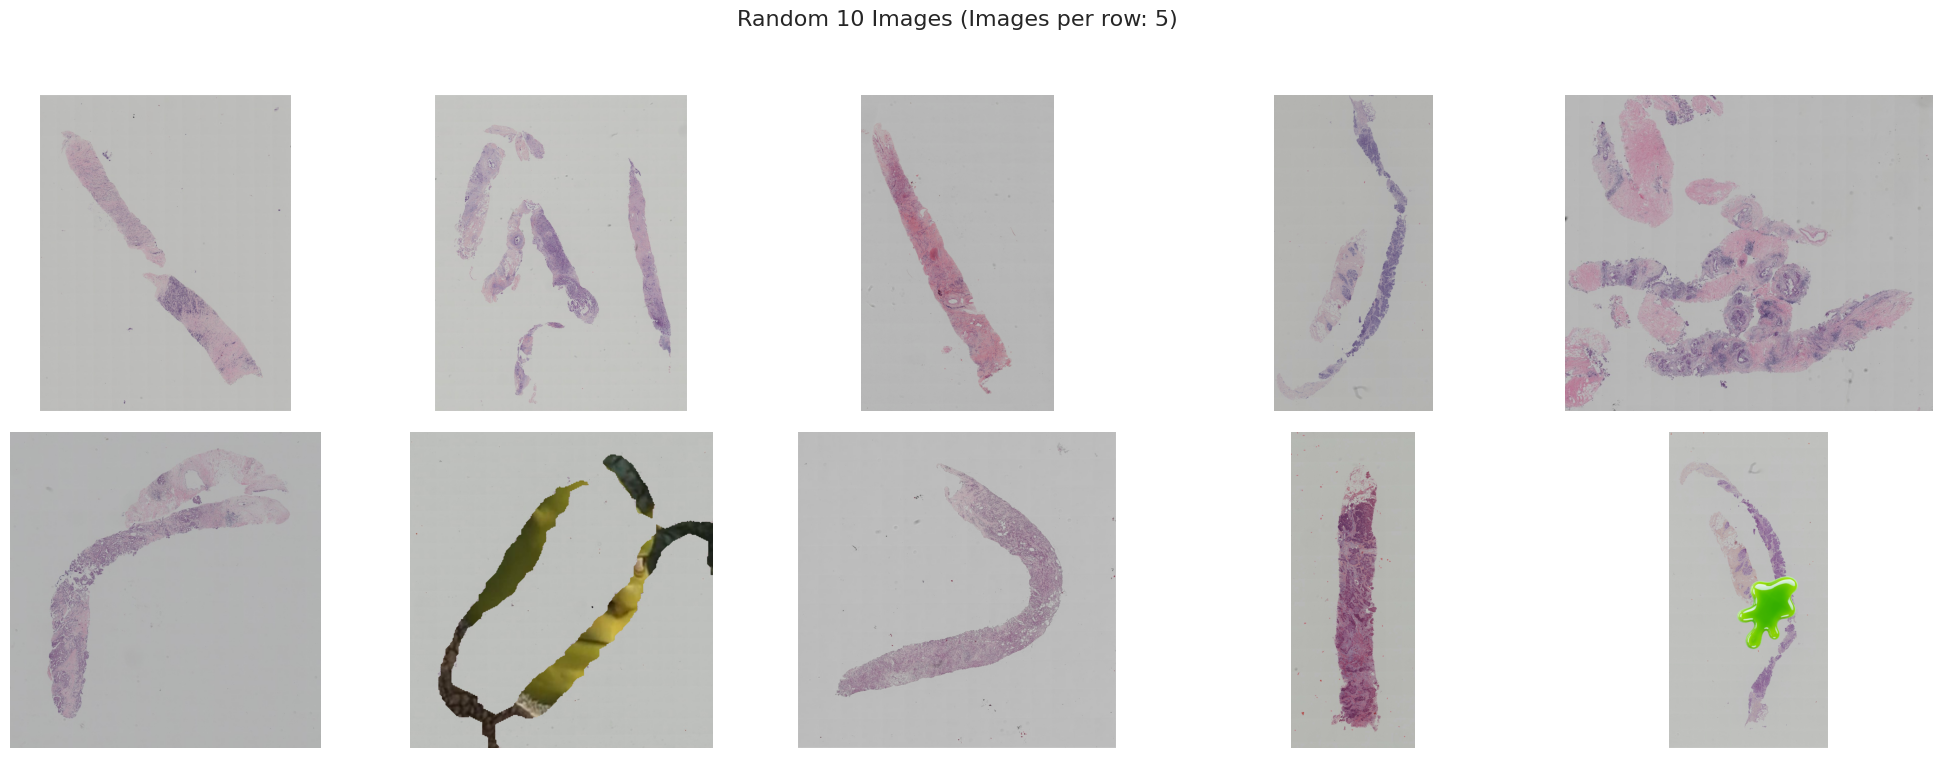

In [48]:
def plot_images_from_dataset(dataset, indices, title, images_per_row):
    num_images = len(indices)
    rows = math.ceil(num_images / images_per_row)

    fig, axes = plt.subplots(rows, images_per_row, figsize=(20, rows * 4))
    fig.suptitle(title, fontsize=16)

    if rows == 1 and images_per_row == 1:
        axes = [axes]
    elif rows == 1:
        # If only one row but multiple columns, axes is a 1D array
        pass
    else:
        axes = axes.flatten()

    for i, idx in enumerate(indices):
        ax = axes[i]
        ax.imshow(np.clip(dataset.image(idx), 0, 1))
        ax.axis('off')

    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()


images_per_row = 5 # Customize the number of images per row here

# --- Plotting the first 'images_per_row' images ---
num_first_images = 10
initial_image_indices = list(range(num_first_images))
plot_images_from_dataset(
    ds_train,
    initial_image_indices,
    f"First {num_first_images} Images (Images per row: {images_per_row})",
    images_per_row
)

print("\n\n")

# --- Plotting 'images_per_row' random images ---
num_random_images = 10
# Generate random indices
total_train_images = len(ds_train)
random_indices = random.sample(range(total_train_images), num_random_images)
plot_images_from_dataset(
    ds_train,
    random_indices,
    f"Random {num_random_images} Images (Images per row: {images_per_row})",
    images_per_row
)

---
## 🦠 **Spotting splatters**

In [41]:
splatter_images = []  # (idx, image_id, ratio)

# --- 1. Improved Green Splatter Detection ---
def detect_green_splatter(image_rgb):
    """
    Detects bright, artificial green splatters using HSV thresholding.
    Input: image_rgb (numpy array, float32 [0,1] or uint8 [0,255])
    """
    # Convert from [0,1] float back to [0,255] uint8 for OpenCV
    if image_rgb.dtype == np.float32 or image_rgb.max() <= 1.0:
        image_uint8 = (image_rgb * 255).astype(np.uint8)
    else:
        image_uint8 = image_rgb.astype(np.uint8)

    # Convert RGB -> HSV
    hsv = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2HSV)

    # Define "Neon Green" Range (Tuned for your splatter artifact)
    # Hue: 40-80 (Centered on Green=60)
    # Saturation: > 100 (Must be colorful, ignores gray/white background)
    # Value: > 100 (Must be bright, ignores dark shadows)
    lower_green = np.array([40, 100, 100])
    upper_green = np.array([80, 255, 255])

    # Create Mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Calculate Ratio (Green Pixels / Total Pixels)
    green_ratio = np.count_nonzero(mask) / mask.size

    # Threshold: 0.5% (0.005) is enough to flag a splatter
    return green_ratio > 0.005, green_ratio


# --- 2. Invocation & Scanning ---
print(f"Scanning {len(ds_train)} images for green splatters...")

for idx in range(len(ds_train)):
    # Retrieve image using your class method (returns RGB float32)
    img = ds_train.image(idx)

    is_splatter, ratio = detect_green_splatter(img)

    if is_splatter:
        # Extract ID
        full_filename = ds_train.image_filenames[idx]
        image_id = os.path.splitext(full_filename)[0]

        # Store tuple: (index, id, ratio)
        splatter_images.append((idx, image_id, ratio))

print(f"\n✅ Found {len(splatter_images)} images with splatters.")

Scanning 1412 images for green splatters...

✅ Found 101 images with splatters.


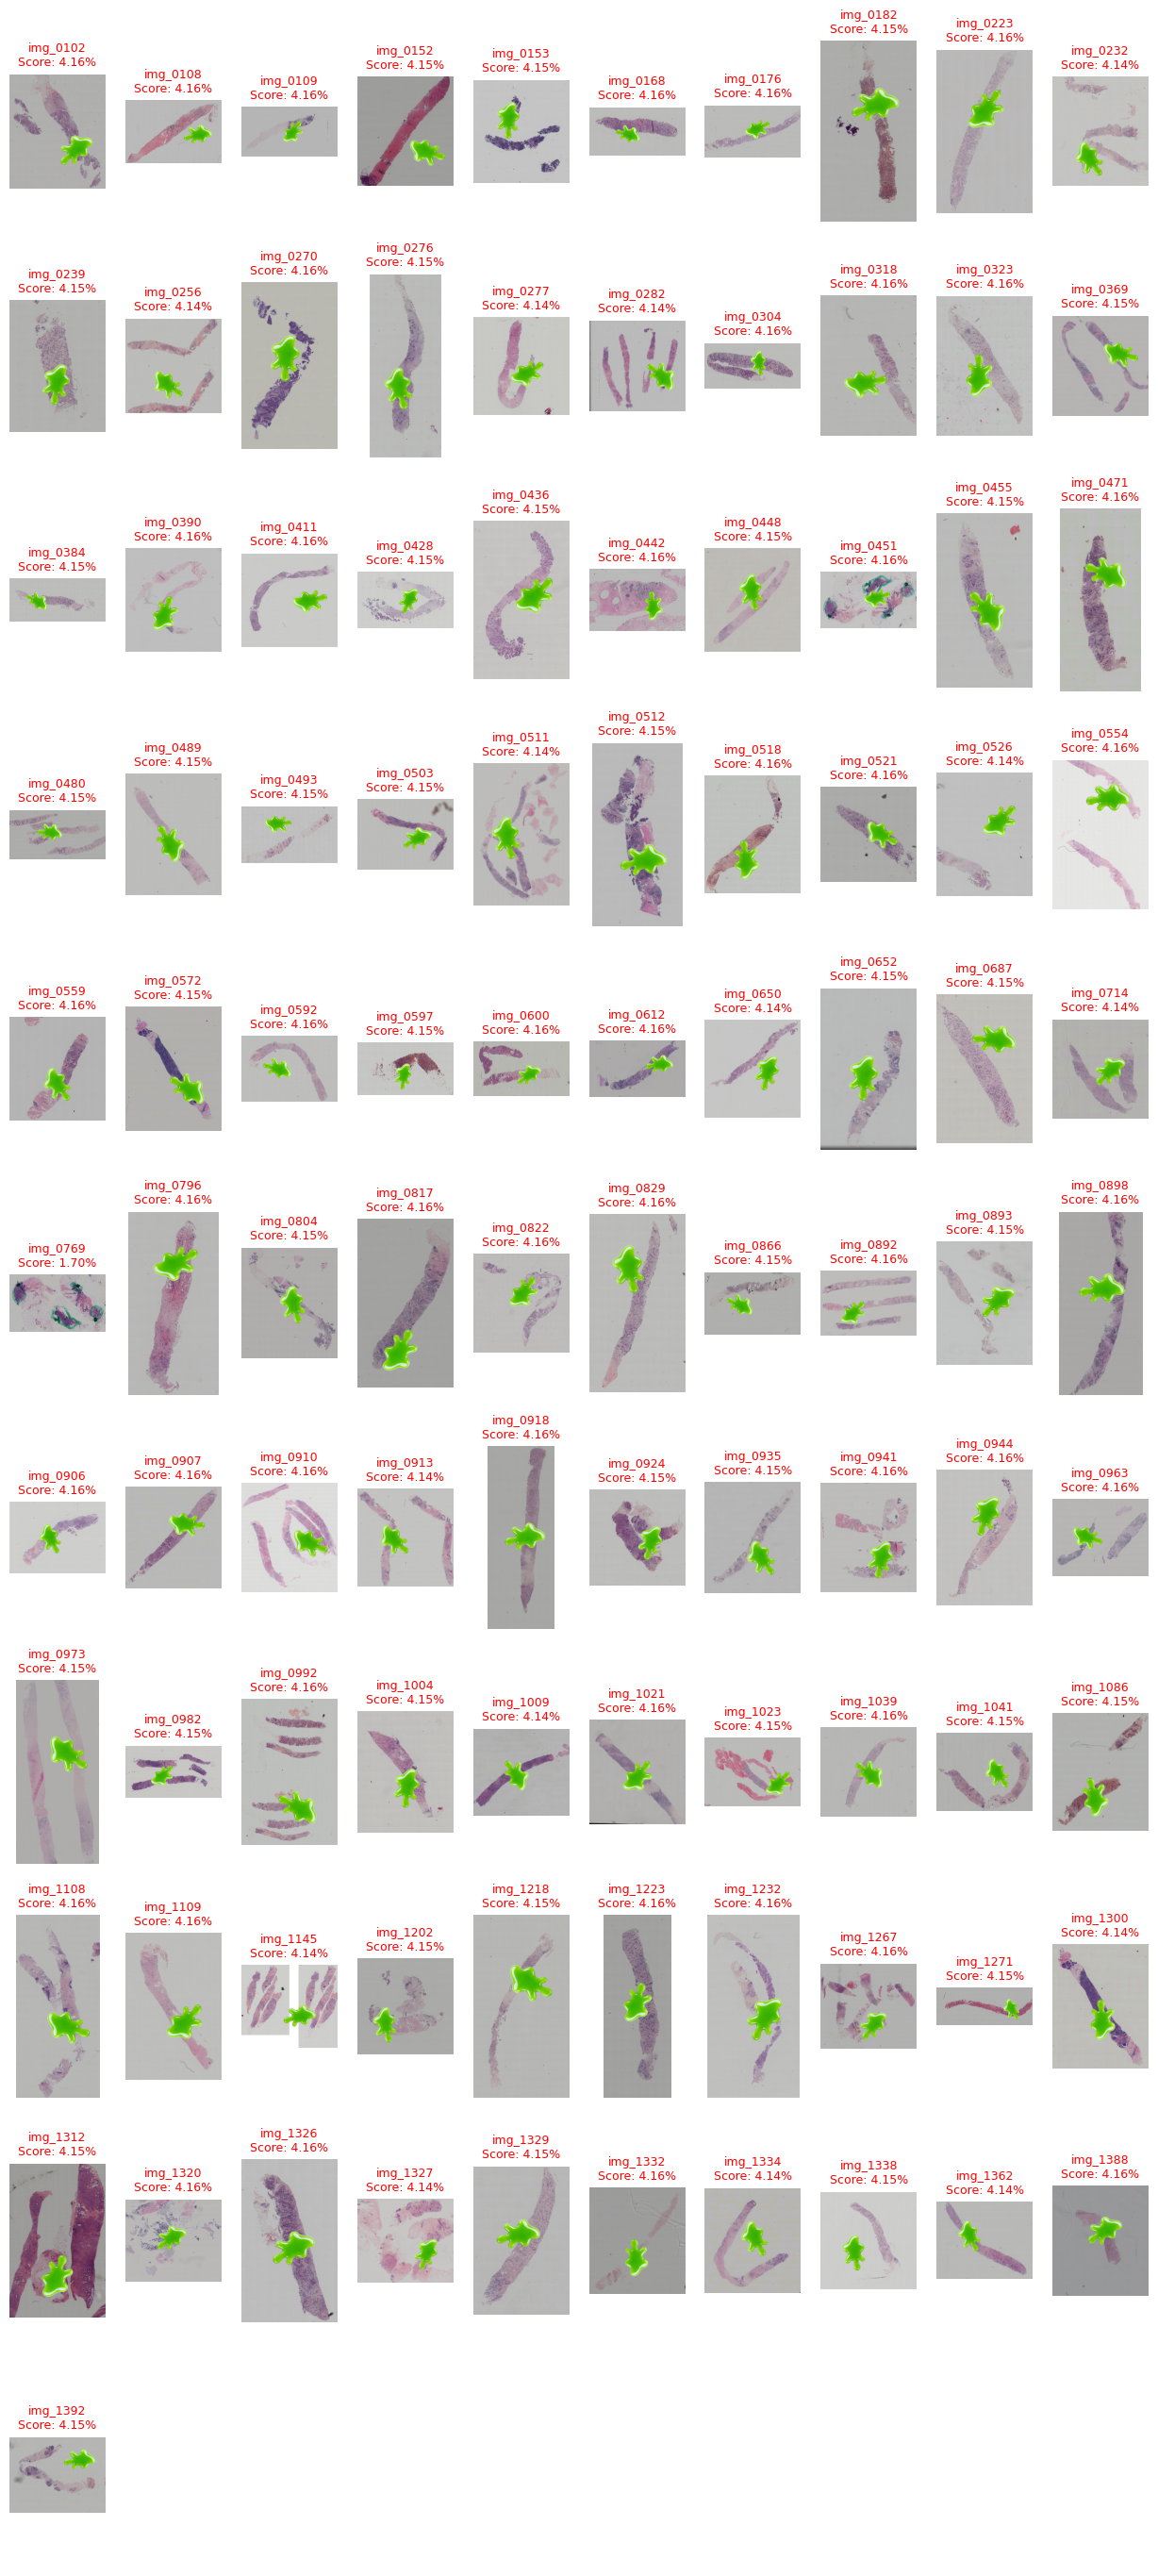

In [40]:
# --- 3. Plotting Miniatures ---
if len(splatter_images) > 0:
    # Configure Grid
    cols = 10
    rows = math.ceil(len(splatter_images) / cols)

    # Create Figure
    fig, axes = plt.subplots(rows, cols, figsize=(12.5, 2.5 * rows))

    # Flatten axes array for easy iteration (handles single row case too)
    if rows == 1 and cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, (idx, img_id, ratio) in enumerate(splatter_images):
        # Fetch image again for visualization
        img = ds_train.image(idx)

        ax = axes[i]
        ax.imshow(img)
        # Title with ID and Green Score
        ax.set_title(f"{img_id}\nScore: {ratio:.2%}", fontsize=9, color='red')
        ax.axis('off')

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No splatters detected. Try lowering the threshold if you are sure they exist.")

### 🧹 **Cleanup dataset, segregate splatter**

In [71]:
# --- Configuration ---
# Source directory (where your original train_data is)
SOURCE_DIR = ds_train.data_dir  # e.g., .../train_data
# Destination directories
CLEAN_DIR = os.path.join(ds_train.root_dir, 'train_data_splatter_free')
SPLATTER_DIR = os.path.join(ds_train.root_dir, 'train_data_splatter')

# Create directories if they don't exist
os.makedirs(CLEAN_DIR, exist_ok=True)
os.makedirs(SPLATTER_DIR, exist_ok=True)

print(f"📂 Source: {SOURCE_DIR}")
print(f"✅ Clean Dest: {CLEAN_DIR}")
print(f"☢️ Splatter Dest: {SPLATTER_DIR}")

# --- Preparation ---
# 1. Create a set of Splatter IDs for O(1) fast lookup
# splatter_images is a list of tuples: (index, image_id, ratio)
# We assume image_id is "img_XXXX" (without extension)
splatter_ids_set = set([item[1] for item in splatter_images])

# 2. Get list of all files in source
all_files = os.listdir(SOURCE_DIR)

# --- Execution ---
print("\n🚀 Starting Copy Process...")

copy_count_clean = 0
copy_count_splatter = 0

for filename in tqdm(all_files):
    # Skip non-files (directories) if any
    if not os.path.isfile(os.path.join(SOURCE_DIR, filename)):
        continue

    # We only care about images/masks, not random system files
    # Check if it's an image or a mask belonging to an image
    name_without_ext = os.path.splitext(filename)[0]

    # Heuristic: Check if the file is associated with a splatter ID
    # If filename is "img_0123.png", ID is "img_0123" -> Check set
    # If filename is "mask_0123.png", we need to map it to "img_0123" to check set

    is_splatter = False

    if filename.startswith("img_"):
        if name_without_ext in splatter_ids_set:
            is_splatter = True

    elif filename.startswith("mask_"):
        # Convert "mask_0123" -> "img_0123" to check against our splatter list
        associated_img_id = name_without_ext.replace("mask_", "img_")
        if associated_img_id in splatter_ids_set:
            is_splatter = True

    # Construct paths
    src_path = os.path.join(SOURCE_DIR, filename)

    if is_splatter:
        dst_path = os.path.join(SPLATTER_DIR, filename)
        shutil.copy2(src_path, dst_path) # copy2 preserves metadata
        copy_count_splatter += 1
    else:
        dst_path = os.path.join(CLEAN_DIR, filename)
        shutil.copy2(src_path, dst_path)
        copy_count_clean += 1

print("\n--- Summary ---")
print(f"✅ Clean files copied: {copy_count_clean}")
print(f"☢️ Splatter files copied: {copy_count_splatter}")
print("Done.")

📂 Source: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Second Challenge/grumpy-doctogres/train_data
✅ Clean Dest: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Second Challenge/grumpy-doctogres/train_data_splatter_free
☢️ Splatter Dest: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Second Challenge/grumpy-doctogres/train_data_splatter

🚀 Starting Copy Process...


100%|██████████| 2824/2824 [02:20<00:00, 20.17it/s]


--- Summary ---
✅ Clean files copied: 2622
☢️ Splatter files copied: 202
Done.


In [73]:
# --- Configuration ---
original_csv_path = os.path.join(ds_train.root_dir, 'train_labels.csv')
new_csv_path = os.path.join(ds_train.root_dir, 'train_labels_splatter_free.csv')

# --- Execution ---
print(f"Reading labels from: {original_csv_path}")
df = pd.read_csv(original_csv_path)
initial_count = len(df)

# 1. Create a Set of "Bad" IDs for fast lookup
# splatter_images contains tuples like (index, "img_1234", score)
# We extracted the ID without extension previously.
bad_ids_set = set([item[1] for item in splatter_images])

print(f"Filtering out {len(bad_ids_set)} splatter images...")

# 2. Filter the DataFrame
# We need to extract the ID from the CSV 'sample_index' (which is "img_XXXX.png")
# to match the IDs in our bad_ids_set (which is "img_XXXX")

def extract_id(filename):
    return os.path.splitext(filename)[0]

# Create a boolean mask: True if the row's ID is in the bad set
# We use apply() to handle the extension stripping safely
mask_is_splatter = df['sample_index'].apply(extract_id).isin(bad_ids_set)

# Select rows that are NOT splatters (~)
df_clean = df[~mask_is_splatter].copy()

# 3. Save the new CSV
df_clean.to_csv(new_csv_path, index=False)

# --- Summary ---
print("\n--- CSV Creation Summary ---")
print(f"Original rows:  {initial_count}")
print(f"Removed rows:   {mask_is_splatter.sum()}")
print(f"Remaining rows: {len(df_clean)}")
print(f"✅ Labels Dest: {new_csv_path}")

# Sanity Check: Print first few rows of the new CSV
print("\nHead of new CSV:")
print(df_clean.head())

Reading labels from: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Second Challenge/grumpy-doctogres/train_labels.csv
Filtering out 101 splatter images...

--- CSV Creation Summary ---
Original rows:  1412
Removed rows:   101
Remaining rows: 1311
✅ Labels Dest: /gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Second Challenge/grumpy-doctogres/train_labels_splatter_free.csv

Head of new CSV:
   sample_index            label
0  img_0000.png  Triple negative
1  img_0001.png        Luminal A
2  img_0002.png        Luminal A
3  img_0003.png        Luminal B
4  img_0004.png          HER2(+)


## 📥 **Splatter-free data loading**

In [77]:
# Load splatter-free dataset
ds_train_splatter_free = GrumpyDoctogresDataset(
    mode='train', root_dir=dataset_dir,
    data_dir='train_data_splatter_free',
    labels_df=pd.read_csv(os.path.join(dataset_dir, 'train_labels_splatter_free.csv')))
print(f"Loaded {len(ds_train_splatter_free)} training samples.")

Loaded 1311 training samples.


---

---

---

# È SOLO UN ESEMPIO, PROBABILMENTE DA USARE COSÌ QUANDO TRAINEREMO UN MODELLO

In [66]:
# 1. Read the clean CSV to get indices
trainval_labels_csv_path = os.path.join(dataset_dir, 'train_labels_splatter_free.csv')
df_trainval_labels = pd.read_csv(trainval_labels_csv_path)

# 2. Calculate Split Indices
train_idxs, val_idxs = train_test_split(
    df_trainval_labels.index,
    test_size=0.2,
    stratify=df_trainval_labels['label'],
    random_state=SEED
)

# 3. Create Datasets using 'filter_indices'
ds_train_splatter_free = GrumpyDoctogresDataset(
    mode='train',
    root_dir=dataset_dir,
    data_dir='train_data_splatter_free',
    labels_df=df_trainval_labels,
    filter_indices=train_idxs,
    transform=None # TODO - Transformations to decide and add
)

ds_val_splatter_free = GrumpyDoctogresDataset(
    root_dir=dataset_dir,
    mode='train',
    data_dir='train_data_splatter_free',
    labels_df=df_trainval_labels,
    filter_indices=val_idxs,
    transform=None # TODO - Needed transformations for validation ???
)

print(f"Train size: {len(ds_train_splatter_free)} | Val size: {len(ds_val_splatter_free)}")

ℹ️ Subset initialized: 1048 samples.
ℹ️ Subset initialized: 263 samples.
Train size: 1048 | Val size: 263
